In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import ReLU
from torch.utils.data import Dataset, DataLoader
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import random

# Solving for the MET of a particle in double well potential landscape in a disk with "Boundary Adapted PINNs": comparison with exact solution

## 1) Setup

For $\theta,\sigma,r >0$ some fixed parameters, we let $\Omega := B_r \equiv \{x\in\mathbb R^d : \|x\|< r \}$, $x_1, x_2\in\Omega$ be fixed and define the process ($d=2$ in our illustration) :

$$\begin{cases} dX_t &= -\theta (X_t - x_1 + X_t - x_2) dt + \sigma dB_t \\
X_0 &= x \in \Omega \end{cases} $$

For all $x\in\Omega$, let

$$T(x) := \inf\{t\ge 0 : X_t \in\partial\Omega\} $$

and let its first moment be denoted

$$\tau(x) := \mathbb E[T(x)] $$

We can show under some regularity conditions on $\Omega$ that $\tau$ is the (unique) solution of the BVP :

$$\begin{cases} -\mathcal{L}u(x) &= 1 \text{ for all } x\in\Omega \\
u(x) &= 0 \text{ for all } x\in\partial\Omega \end{cases} $$

where $\mathcal L$ is the infinitesimal generator of the Ornstein-Uhlenbeck process, given by
$$\mathcal Lu : x \mapsto -\theta(2x - x_1 - x_2)\cdot \nabla u(x) + \frac{\sigma^2}{2}\Delta u(x) $$

## 2) Setting up the Neural Network architecture and loss function

Unlike the standard PINN, we will take an hypothesis space of Neural Networks which satisfy the boundary conditions explicitly. For this problem, we have homogenous zero Dirichlet boundary conditions, which we can enforce by multiplying our Neural Networks with an appropriate "smooth distance approximation" (see https://arxiv.org/abs/2104.08426). In accordance with the mentioned paper, we will take
$$\varphi : x\mapsto \frac{r^2 - \|x\|^2}{2r}$$
as our smooth distance approximation.  


With this modification, our objective to minimize becomes
$$\hat u := \arg\min_{u\in\mathcal{NN}_\varphi}\ \frac1n \sum_{i=1}^n (\mathcal L u(x_i^c) + 1)^2 $$
where $x_i^c$ are sampled i.i.d. with uniform distribution on $\Omega$,
$$\mathcal{NN}_\varphi:=\left\{x\mapsto \varphi(x) \cdot T_L\circ \sigma^k \circ T_{L-1}\circ\cdots\circ \sigma^k\circ T_1 (x)\right\}, $$
for
$$T_\ell : \mathbb{R}^{\ell-1}\to\mathbb{R}^\ell $$
affine-linear maps of appropriate input-output dimensions, where
$$\sigma_k :x \mapsto \begin{cases}x^k &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} $$
is the ReLU$^k$ activation, which is understood element-wise when applied to vectors.

In [2]:
#pde parameters
radius = 2.0
sigma = 1.0
theta = 0.5
x_1 = torch.tensor(1/np.sqrt(2), dtype=torch.float64)
y_1 = torch.tensor(1/np.sqrt(2), dtype=torch.float64)
x_2 = torch.tensor(-1/np.sqrt(2), dtype=torch.float64)
y_2 = torch.tensor(-1/np.sqrt(2), dtype=torch.float64)

radius_double = torch.tensor(2.0, dtype=torch.float64)
sigma_double = torch.tensor(1.0, dtype=torch.float64)
theta_double = torch.tensor(0.5, dtype=torch.float64)


#define our NN architecture
power = 2 #exponent k for relu^k
width = 50
depth = 3
magnitude = 0.8 #magnitude of weights at initialization

#define ReLU^k activation

class RePU(nn.Module):
    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)


#define the smooth distance approximation
def smooth_distance(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    return (radius_double**2 - norm_x**2)/(2*radius_double)


#define hypothesis space
class BoundaryPINN(nn.Module):
    def __init__(self, power = power, width = width, depth = depth):
        super(BoundaryPINN,self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, width))
        self.layers.append(RePU(power))
        for _ in range(depth-1) :
            self.layers.append(nn.Linear(width, width))
            self.layers.append(RePU(power))
        self.layers.append(nn.Linear(width, 1))


    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        distance =  smooth_distance(x)
        return output**2 * distance.unsqueeze(-1)


In [3]:
#all functions needed for training

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    This function calculates the derivative of the model at x
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy, dtype=torch.float64),
            create_graph=True, retain_graph=True
        )[0]
    return dy

def u_function(model: BoundaryPINN, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the model on the input x
    """
    model_input = torch.stack((x, y), axis = 1)
    return model(model_input)


def residual(model, x_c, y_c, theta, sigma):
    u = u_function(model, x_c, y_c)
    u_x = derivative(u, x_c, order=1)
    u_y = derivative(u, y_c, order=1)
    u_xx = derivative(u, x_c, order=2)
    u_yy = derivative(u, y_c, order=2)
    res = - theta * ((2 * x_c-x_1 - x_2) * u_x \
                     + (2 * y_c- y_1 - y_2) * u_y) \
        + sigma**2 * (u_xx + u_yy)/2 \
        + 1
    return res

def loss_function(model: BoundaryPINN, x_c: torch.Tensor, y_c: torch.Tensor, theta, sigma) -> torch.Tensor:
    """
    This function evaluates the physics governing the model on the input x
    """
    res = residual(model, x_c, y_c, theta, sigma)
    return torch.mean(res**2)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=magnitude)
        m.bias.data.fill_(magnitude)

## 3) Verification of the collocation points for training

sampling $n = N_c$ collocation points in $\Omega$.

In [4]:
N_c = 2048 #number of points in the domain

#definition of X_c_train : N_c points in the disk
t = np.random.uniform(0,2*np.pi, N_c)
rho = np.sqrt(np.random.uniform(0,radius**2, N_c)) #uniform distribution on the disk
x_c = rho * np.cos(t)
y_c = rho * np.sin(t)
X_c_train = np.vstack( (x_c, y_c) )

#shuffling X_c_train
index = np.arange(0, N_c)
np.random.shuffle(index)
X_c_train = X_c_train[:,index]

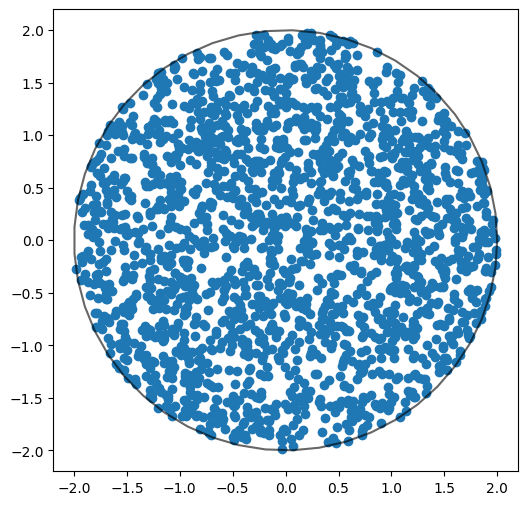

In [5]:
#checking the collocation points

#circle
a = np.linspace(0, 2*np.pi, 50)
cx,cy = np.cos(a) * radius , np.sin(a)*radius

plt.figure(figsize=(6, 6))
plt.plot(cx,cy,'k-', alpha=.6)
plt.scatter(x_c,y_c)

In [6]:
class TrainingData(Dataset):
    def __init__(self, X_c):
        self.X_c = X_c

    def __len__(self):
        return self.X_c.shape[1]

    def __getitem__(self, index):
        X_c = self.X_c[:, index]
        return X_c

## 4) Training loop function

In [7]:
#adam
def train_one_epoch(model, optimizer, theta, sigma, losses):
    running_loss = 0.
    last_loss = 0.
    n_display = (N_c//batch_size)//3

    for i, X_c in enumerate(dataloader):

        x_c = X_c[0,:]
        y_c = X_c[1,:]

        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss = loss_function(model, x_c, y_c, theta, sigma)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if (i+1) % n_display == 0 :
            last_loss = running_loss / n_display # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            losses.append(last_loss)
            running_loss = 0.

    return last_loss

In [8]:
#l-bfgs
def training_loop_lbfgs(model, optimizer, theta, sigma, losses):

    iter = 0

    for X_c in dataloader_bfgs:
        x_c = X_c[0,:]  # Collocation points (x-coordinates)
        y_c = X_c[1,:]  # Collocation points (y-coordinates)

    # Define the closure function required by L-BFGS
    def closure():
        nonlocal iter
        optimizer.zero_grad()  # Clear previous gradients

        # Compute total loss
        loss = loss_function(model, x_c, y_c, theta, sigma)
        loss.backward()  # Backpropagation to compute gradients

        # Log the loss for the current iteration
        print(f'L-BFGS Iteration {iter}: Loss = {loss.item()}')
        losses.append(loss.item())
        iter += 1
        return loss

    # Perform one optimization step
    optimizer.step(closure)

    final_loss = loss_function(model, x_c, y_c, theta, sigma).item()

    # Gather data and report
    print('Full-batch loss: {}'.format(final_loss))
    losses.append(final_loss)  # Append the final loss to the losses list

    return final_loss

## 5) Curriculum training

In [9]:
nb_curriculum = 1
thetas = [theta] * nb_curriculum
sigmas = [sigma] * nb_curriculum #np.linspace(theta * nb_curriculum, sigma, nb_curriculum).tolist()
losses = [[] for _ in range(nb_curriculum)]
losses_lbfgs = [[] for _ in range(nb_curriculum)]

#training parameters
n_batches = 8 #<= N_c
batch_size = max(4, N_c//n_batches)
learning_rate_adam = 5e-4
method = 'Adam' #'SGD' or 'Adam', Adam strongly recommended
n_epochs = 10_000
n_decreases = 200
damping = 1e-3
gamma = damping**(1/n_decreases) #damp the learning rate by a factor of 'damping' by the end of training

#first training batch
#convert numpy array to tensor and load it
X_c_train_tensor = torch.from_numpy(X_c_train).requires_grad_(True).double()
dataset = TrainingData(X_c_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_bfgs = DataLoader(dataset, batch_size=len(dataset), shuffle=True)

In [10]:
#download a pretrained model
#!wget https://raw.githubusercontent.com/StratosFair/Mean_Escape_Time/main/OU_process/Models/boundary_pinn_theta=0.5_sigma=1.pt -O boundary_pinn_pretrained.pt

In [ ]:
for i in range(nb_curriculum):

    print("------CURRICULUM TRAINING: {0}/{1}------".format(i+1, nb_curriculum))

    #update parameter values
    theta = thetas[i]
    sigma = sigmas[i]

    #load model and set optimizer
    if i > 0:
        checkpoint = torch.load(f'boundary_pinn_curriculum_{i}_lbfgs.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.double()
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Scale the learning rate back up
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate_adam  # Reset to original learning rate

    else:
        model = BoundaryPINN(power=power, width=width, depth=depth).double()

        if os.path.isfile('boundary_pinn_pretrained.pt'):
            pretrained_checkpoint = torch.load('boundary_pinn_pretrained.pt')
            model.load_state_dict(pretrained_checkpoint['model_state_dict'])
            model = model.double()

        else:
            model.apply(init_weights)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)

    # Define or continue scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=n_epochs // n_decreases, gamma=gamma
    )

    #train model for current curriculum
    for epoch in range(n_epochs):
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, optimizer, theta, sigma, losses[i])
        scheduler.step()
        print('LOSS train {}'.format(avg_loss))

    #save trained model
    if n_epochs>0:
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, f'boundary_pinn_curriculum_{i+1}.pt')

    # ---- SWITCH TO L-BFGS FOR FINE-TUNING ----
        print("Switching to L-BFGS for fine-tuning...")

    # Initialize L-BFGS optimizer
    lbfgs_optimizer = torch.optim.LBFGS(model.parameters(),
                                        max_iter=1000, # Allow more iterations
                                        tolerance_grad=1e-10,      # Stricter gradient tolerance
                                        tolerance_change=1e-12,   # Stricter tolerance for parameter changes
                                        line_search_fn="strong_wolfe"  # More robust line search
                                        )

    # Train one epoch with L-BFGS
    final_loss = training_loop_lbfgs(model, lbfgs_optimizer, theta, sigma, losses_lbfgs[i])

    # Log the final loss
    print(f"L-BFGS fine-tuning loss: {final_loss}")

    # Save the model after L-BFGS fine-tuning
    torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': lbfgs_optimizer.state_dict(),
            }, f'boundary_pinn_curriculum_{i + 1}_lbfgs.pt')

------CURRICULUM TRAINING: 1/1------
EPOCH 1:
  batch 2 loss: 5.473665558332595
  batch 4 loss: 1.5421808258980443
  batch 6 loss: 1.2745351280645048
  batch 8 loss: 11.319458927790247
LOSS train 11.319458927790247
EPOCH 2:
  batch 2 loss: 3.3799690314019815
  batch 4 loss: 0.7049068702254857
  batch 6 loss: 1.5966280826338106
  batch 8 loss: 1.7587756640698702
LOSS train 1.7587756640698702
EPOCH 3:
  batch 2 loss: 2.0875575405862556
  batch 4 loss: 2.2421637429631627
  batch 6 loss: 9.269608954469629
  batch 8 loss: 11.894096359484745
LOSS train 11.894096359484745
EPOCH 4:
  batch 2 loss: 0.7515397989839555
  batch 4 loss: 0.9561280733119842
  batch 6 loss: 0.6504900933437566
  batch 8 loss: 1.3700549119725793
LOSS train 1.3700549119725793
EPOCH 5:
  batch 2 loss: 1.007185406317862
  batch 4 loss: 1.20046529521811
  batch 6 loss: 1.6004147179661858
  batch 8 loss: 1.6559068932761738
LOSS train 1.6559068932761738
EPOCH 6:
  batch 2 loss: 2.376841198507519
  batch 4 loss: 1.512094122387

In [ ]:
 #if training got interrupted manually, save:
# torch.save({'epoch': n_epochs,
#                'model_state_dict': model.state_dict(),
#                'optimizer_state_dict': optimizer.state_dict(),
#                'loss': avg_loss
#                }, f'boundary_pinn_interrupt.pt')

## 6) Visualizing the training

In [ ]:
# Visualization for training losses across curriculum steps
if nb_curriculum < 3:
    # If the number of curricula is less than 3, plot only the last curve
    plt.figure(figsize=(8, 6))
    plt.loglog(losses[-1], label=f'Adam({nb_curriculum}/{nb_curriculum})', color='C0')
    plt.loglog(losses_lbfgs[-1], label=f'L-BFGS ({nb_curriculum}/{nb_curriculum})', color='C1')
    plt.title(f'Training Loss for Curriculum PINN', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss (log scale)', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

else:
    # If there are 3 or more curricula, plot the 1st, middle, and last curves
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Determine which curricula to plot: first, middle, last
    curricula_to_plot = [nb_curriculum // 3, 2 * nb_curriculum // 3, nb_curriculum - 1]
    titles = [
        f'Curriculum: {nb_curriculum // 3}/{nb_curriculum}',
        f'Curriculum: {2 * nb_curriculum // 3}/{nb_curriculum}',
        f'Final Curriculum: {nb_curriculum}/{nb_curriculum}'
    ]

    # Loop over the subplots to plot the chosen curricula
    for i, ax in enumerate(axs):
        ax.loglog(losses[curricula_to_plot[i]], label="Adam: " + titles[i], color=f'C{i}')
        ax.loglog(losses_lbfgs[curricula_to_plot[i]], label="L-BFGS: " + titles[i], color=f'C{i+3}')
        ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel('Epochs', fontsize=12)
        ax.set_ylabel('Loss (log scale)', fontsize=12)
        ax.legend(fontsize=10, loc='upper right')
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

## 6bis) Training for longer if convergence isn't attained [optional]

In [ ]:
# #reloading the previously saved checkpoint
# checkpoint = torch.load(f'boundary_pinn_{method}.pt')

# #intialization of the model and optimizer
# model = BoundaryPINN(power=power, width=width, depth=depth)

# extra_epochs = 10_000
# n_decreases = 100
# learning_rate_adam = 1e-4
# damping = 1e-2
# gamma = damping**(1/n_decreases)

# if method == 'Adam':
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer,\
#                                                     step_size=extra_epochs//n_decreases,\
#                                                     gamma=gamma)


# #reloading of parameters from end of previous training
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# #retrain for 'extra_epochs'
# for epoch in range(start_epoch+1, start_epoch + extra_epochs):
#         #epoch_number += 1
#         print('EPOCH {}:'.format(epoch))

#         # Make sure gradient tracking is on, and do a pass over the data
#         model.train(True)
#         avg_loss = train_one_epoch(model, optimizer, zeta, eps, losses[i])
#         scheduler.step()
#         print('LOSS train {}'.format(avg_loss))

# #save the further trained model and reset optimizer
# torch.save({'epoch': start_epoch + extra_epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss
#             }, f'boundary_pinn_{method}.pt')

## 7) Visualizing the results

In [ ]:
#load the model to plot
interrupt = False
n_plot = nb_curriculum

if os.path.isfile('boundary_pinn_interrupt.pt'):
    interrupt = True
    final_checkpoint = torch.load('boundary_pinn_interrupt.pt')
    model.load_state_dict(final_checkpoint['model_state_dict'])

else:
    n_plot = nb_curriculum #<= nb_curriculum
    final_checkpoint = torch.load(f'boundary_pinn_curriculum_{n_plot}_lbfgs.pt')
    model.load_state_dict(final_checkpoint['model_state_dict'])

#evaluate the model on a uniform grid
n_points = 150
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid
xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0) #(https://stackoverflow.com/questions/15733530/)
#zz_true = true_solution_vectorized(xx,yy)

input = torch.from_numpy(np.vstack((xx.ravel(),yy.ravel())).T).double()#.requires_grad_(False)
learned_sol = model(input)

#plot
learned_sol_np = learned_sol.detach().numpy().reshape(xx.shape)
#learned_sol_smooth = ndimage.gaussian_filter(learned_sol_np, sigma=0.1, order=0) #smoothing for visualization

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)
contour = ax.contourf(xx, yy, learned_sol_np, levels=200)
ax.set_title(f'Boundary PINN solution: Curriculum {n_plot}/{nb_curriculum} (interrupt={interrupt})')
cb = fig.colorbar(contour, ax=ax)

In [ ]:
#verify that the model is zero on the boundary
circle = torch.from_numpy(np.vstack((cx.ravel(),cy.ravel())).T).double().requires_grad_(False)
torch.sum(model(circle)**2) #== 0